## Celestial Body Categorical Classifier

This project demonstrates the use of curated data, the construction of a neural network using PyTorch, and the assessment and comparison of multiple models.

The first step is to import the libraries we will be using, as well as our data. This data has already been cleaned so we do not need to fiddle with null values. We read the CSV file using Pandas, then convert the Pandas dataframe to a NumPy array for use with PyTorch. The variable $X$ will be our array of features and the variable $T$ will be our target values.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


# Let's import the processed data
!wget https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_labels.csv
!wget https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_features.csv

--2023-09-14 22:44:44--  https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250000 (244K) [text/plain]
Saving to: ‘Skyserver_SQL_labels.csv.1’

Skyserver_SQL_label 100%[===================>] 244.14K  --.-KB/s    in 0.006s  

2023-09-14 22:44:44 (38.9 MB/s) - ‘Skyserver_SQL_labels.csv.1’ saved [250000/250000]

--2023-09-14 22:44:44--  https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [30]:
X = pd.read_csv('/content/Skyserver_SQL_features.csv').to_numpy()
T = pd.read_csv('/content/Skyserver_SQL_labels.csv').to_numpy().flatten()

We will also make our own function to split the data into a training set and a test set using NumPy rather than using the SciKit Learn function. This function takes the feature and target arrays, a random seed value, and the fraction of rows that we want in the training set. For this model, we'll be using a 90/10 training to test data ratio.

In [31]:
def TTsplit(x, t, seed, split):
  np.random.seed(seed)
  integerIndices = np.linspace(0, len(x)-1, (len(x)), dtype=int)
  np.random.shuffle(integerIndices)

  edge = int(np.ceil(split*len(t)))

  x_train = x[integerIndices[0:edge]]
  x_test = x[integerIndices[edge:]]
  t_train = t[integerIndices[0:edge]]
  t_test = t[integerIndices[edge:]]
  return x_train, x_test, t_train, t_test

X_train, X_test, T_train, T_test = TTsplit(X, T, 42, 0.9)

Now we have to convert the NumPy arrays into PyTorch tensors. The target values for class categorization have to be integers instead of float values, so we make that change as well.

In [32]:
X_train = torch.from_numpy(X_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
T_train = torch.from_numpy(T_train).to(torch.float)
T_test = torch.from_numpy(T_test).to(torch.float)

T_train = T_train.type(torch.LongTensor)
T_test = T_test.type(torch.LongTensor)

The first model we'll be using is a logistic regression model built in PyTorch. A neural network with a single sigmoid layer is the same as a typical logistic regression model.

In [33]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self,x):
        y = torch.sigmoid(self.linear(x))
        return y

Set up the parameters and train the model. We use cross entropy loss since we are performing multi-class classification with sigmoid values.

In [34]:
input_dim = 8
output_dim = 3

model = LogisticRegression(input_dim, output_dim)

optimizer  = torch.optim.SGD(model.parameters(), lr=0.002)

criterion = torch.nn.CrossEntropyLoss()

steps = 30000

In [ ]:
model.train()

for epoch in range(steps):
    optimizer.zero_grad()

    # forward pass
    T_pred = model(X_train)

    # compute loss
    loss = criterion(T_pred, T_train)
    if epoch% 1000 == 0:
        print(loss.item())
    # backward pass
    loss.backward()
    optimizer.step()

We can take a peek at what the result looks like...

In [36]:
for param in model.parameters():
  print(param.data)

tensor([[-0.1791, -0.2570, -0.6764, -0.7690, -0.1740,  0.4560,  1.0567, -1.2436],
        [ 0.0197,  0.0703,  1.3293,  0.4137, -0.2633, -0.7783, -1.0793, -0.1433],
        [-0.0651,  0.0098, -0.2351,  0.3965,  0.0103,  0.1274,  0.1983,  1.3419]])
tensor([ 0.4181,  0.9057, -1.7921])


... and create a function for calculating the accuracy of the model.

In [37]:
def accuracy(targets, predictions):
    predictions = torch.max(predictions.data, 1)[1]
    #this chooses the maximum value that is predicted and returns a 1D tensor of the index of each chosen value (i.e. the predicted label)

    acc = [targets[i]==predictions[i] for i in range(len(targets))]
    return sum(acc)/len(targets)

Let's quickly see what proportion of the data belongs to each class of label to compare against our result.

In [38]:
dfT = pd.DataFrame(T)
dfT.value_counts()/len(dfT)

1.0    0.499850
0.0    0.415142
2.0    0.085009
dtype: float64

If we have an accuracy above 50% then we've beaten the trivial strategy of guessing only class 1 with our model. If our accuracy is less than that, something has gone terribly wrong!

In [39]:
X_train_pred = model(X_train)
X_test_pred = model(X_test)

In [40]:
trainingAccuracy = accuracy(T_train, X_train_pred)
testAccuracy = accuracy(T_test, X_test_pred)

print("Accuracy on training data is " + str(trainingAccuracy))
print("Accuracy on test data is " + str(testAccuracy))

Accuracy on training data is tensor(0.7969)
Accuracy on test data is tensor(0.7978)


The accuracy of our model on the test data, or the validation accuracy, is about 79%, much better than the trivial guessing strategy! But can we make it better? Let's create a more complex neural network and see if that improves our result.

In [41]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()

        self.linear_1 = nn.Linear(input_dim, input_dim*2)
        self.linear_2 = nn.Linear(input_dim*2, input_dim*6)
        self.linear_3 = nn.Linear(input_dim*6, input_dim*12)
        self.linear_4 = nn.Linear(input_dim*12, output_dim)

        self.relu = nn.ReLU()

        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):

        x = self.relu(self.linear_1(x))

        x = self.relu(self.linear_2(x))

        x = self.relu(self.linear_3(x))

        x = self.relu(self.linear_4(x))

        return self.softmax(x)

In [42]:
input_dim = 8
output_dim = 3

model = Net(input_dim, output_dim)

optimizer  = torch.optim.SGD(model.parameters(), lr=0.002)

criterion = torch.nn.CrossEntropyLoss()

steps = 30000

In [ ]:
model.train()

for epoch in range(steps):
    optimizer.zero_grad()

    T_pred = model(X_train)

    loss = criterion(T_pred, T_train)
    if epoch% 1000 == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()

In [44]:
X_train_pred = model(X_train)
X_test_pred = model(X_test)

trainingAccuracy = accuracy(T_train, X_train_pred)
testAccuracy = accuracy(T_test, X_test_pred)

print("Accuracy on training data is " + str(trainingAccuracy))
print("Accuracy on test data is " + str(testAccuracy))

Accuracy on training data is tensor(0.9031)
Accuracy on test data is tensor(0.8949)


An improvement of 10% accuracy! This model is much denser than logistic regression and therefore takes longer to train. However, the logistic regression stops improving earlier than the neural network and with so many more parameters to train, we would expect the neural network to eventually outperform the simpler logistic regression model.

We've shown some of what PyTorch can do. Now we will try a couple out-of-the-box models from SciKit Learn which are easy to implement and have the potential to yield very good results. The first model, principal component analysis or PCA, is more of a linear algebra transformation than a true model, but in some cases is able to cluster data points of the same class together with a relatively inexpensive computation. It does this by reducing the dimensionality of the data while maintaining as much variance as possible in order to retain potential differences between classes.

In [45]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn import svm

In [46]:
pca = PCA(n_components=3)

pca.fit(X)

fit_vals = pca.transform(X)

print(pca.explained_variance_ratio_)

[0.57341756 0.12573896 0.12465592]


<ipython-input-47-45057545334b>:2: UserWarning: Legend does not support handles for set instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend([set(T)], ['0','1','2'])


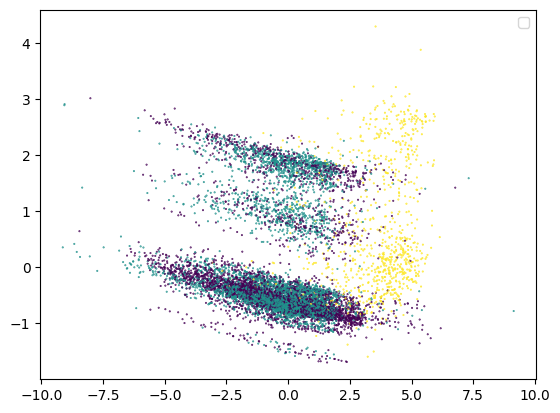

In [47]:
plt.scatter(fit_vals[:,0], fit_vals[:,1], c=T, s=0.2)
plt.legend([set(T)], ['0','1','2'])

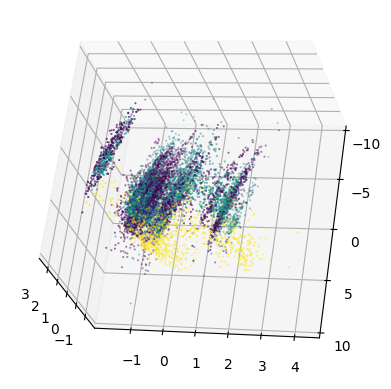

In [48]:
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fit_vals[:,0], fit_vals[:,1], fit_vals[:,2], c=T, s=0.2)
ax.view_init(60, 35, 30)

In [49]:
for i in range(len(fit_vals)):
  if (4< fit_vals[i][0] < 6) & (2.4 < fit_vals[i][1] < 2.8):
    print(T[i])
    break

2.0


The points are colored based on which class they belong to, and in a best case scenario each color would be grouped together distinctly from the others. In our case, in both 2D and 3D the yellow group is relatively separated but the blue and purple groups are highly mixed. With a quick loop we see that a point from the yellow group represents class 2, or quasars. This indicates that galaxies and stars have similar features, while quasars are more easily distinguishable.

The next model we will be implementing is the support-vector machine. This is indeed a supervised model which requires training unlike PCA. It is a linear clasifier that again is relatively inexpensive computationally and can perform better than logistic regression in some situations.

In [50]:
supVecM = svm.SVC(decision_function_shape='ovo')
supVecM.fit(X_train, T_train)

trainScore = supVecM.score(X_train, T_train)
testScore = supVecM.score(X_test, T_test)

print(trainScore)
print(testScore)

0.9674444444444444
0.954954954954955


Wow! The support-vector machine successfully classified 95% of the test data and took only about one second to train. It was also implemented in just two lines of code. While the infinite parameters of a neural network may offer higher potential, ease of use and speed are nontrivial factors to consider when choosing a model.

To finish, let's take a look at one of my favorite plots for visualizing which features best indicate each class: the violin plot. We'll have to re-enter the Pandas environment in order to use the helpful pd.melt function. We'll also give the features their names back for readability on the plot.

In [51]:
import seaborn as sns

In [52]:
dfX = pd.DataFrame(X)
dfT = pd.DataFrame(T)

dfX = dfX.rename(columns={0:"RA", 1:"Dec", 2:"RedS",3:"U",4:"G",5:"R",6:"I",7:"Z"})

dfX['Label'] = dfT

In [53]:
dfMelt = dfX.melt(id_vars=['Label'], value_vars=dfX.columns[:-1])

<Axes: xlabel='variable', ylabel='value'>

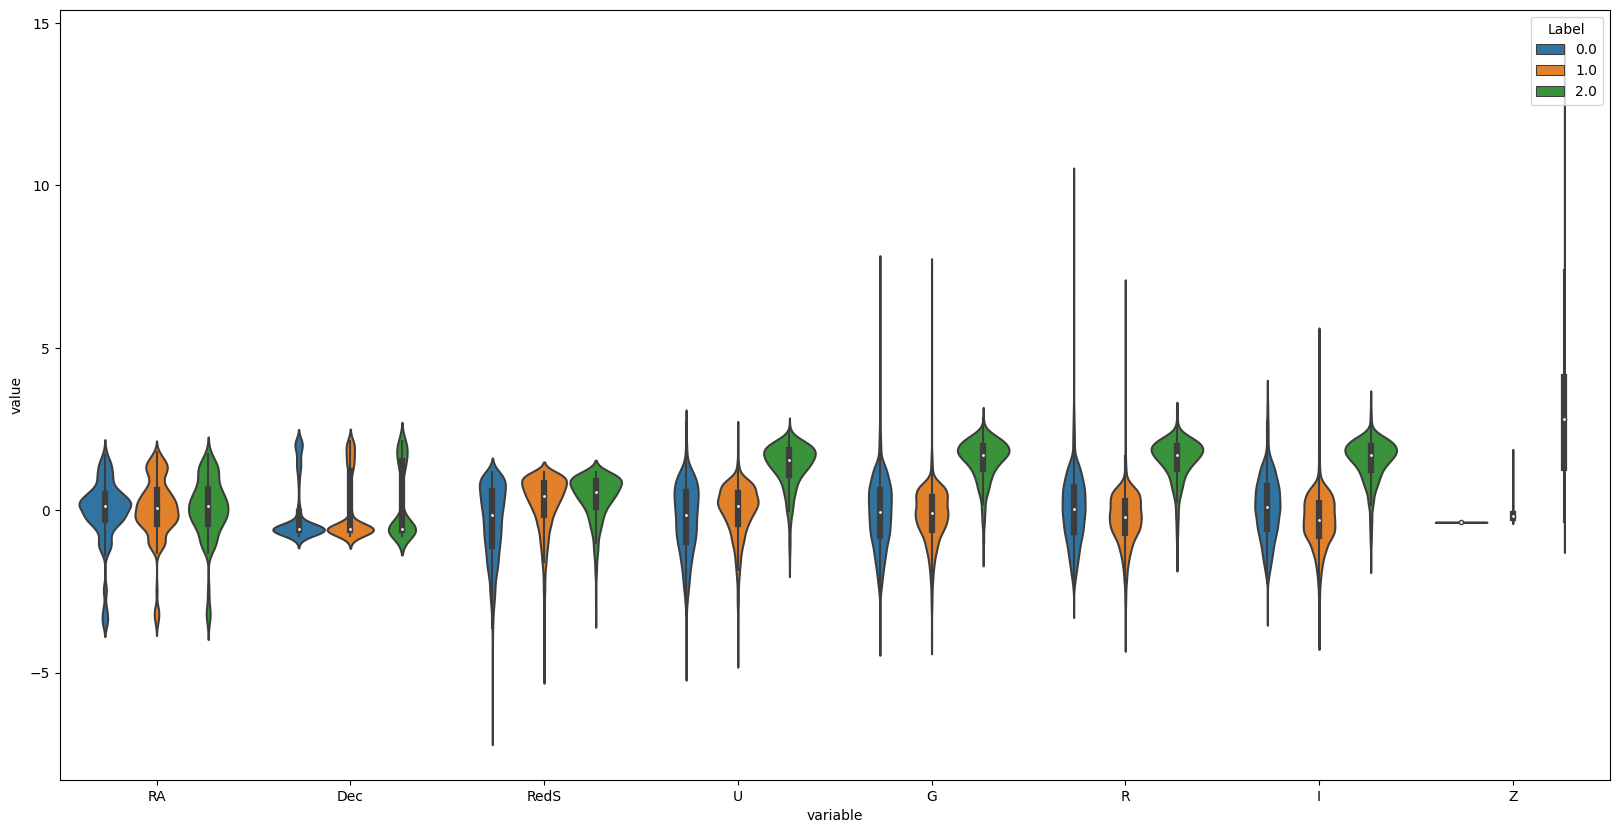

In [54]:
plt.figure(figsize=(20,10))

sns.violinplot(data=dfMelt, x="variable", y="value", hue="Label")

As we might expect given the PCA result, the star and galaxy violins (blue and orange) have similar peaks while quasars (green) clearly peak in a different place for several of the features. Violin plots won't always answer every question, but I find they can be very useful in shedding some light on the results of our black box models.